<a href="https://colab.research.google.com/github/tomhyhan/noodles/blob/main/pasta_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import userdata
from google.colab import auth

auth.authenticate_user()
token = userdata.get('token')
username = userdata.get('username')
repo_name = "noodles"

In [3]:
import os

!git clone https://github.com/tomhyhan/{repo_name}.git

if os.getcwd() != f"/content/{repo_name}":
    %cd {repo_name}
!git pull
!pwd


Cloning into 'noodles'...
remote: Enumerating objects: 233, done.
remote: Counting objects: 100% (233/233), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 233 (delta 129), reused 148 (delta 65), pack-reused 0 (from 0)
Receiving objects: 100% (233/233), 1.16 MiB | 3.70 MiB/s, done.
Resolving deltas: 100% (129/129), done.
/content/noodles
Already up to date.
/content/noodles


In [4]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
import os
import sys

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "noodles"

GOOGLE_DRIVE_PATH = os.path.join("..", "drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)


In [6]:

from model.utils import test_colab
test_colab()


Hello Colab! from Noodles ha


In [7]:
!pip install torchinfo
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 81.6 MB/s eta 0:00:00


In [14]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold


from config.config_manager import ConfigManager
from collections import Counter
from model.data_model import PastaData, create_train_transforms, create_test_transforms
from model.train import trainer, create_model
from model.utils import reset_seed, save_model
from model.data import CLASS_ENCODER, create_csv
from model.viz import class_imbalance, draw_loss, draw_train_val_accuracy

In [15]:
config_manager = ConfigManager("./config/config.yml")

SEED = config_manager.config.seed

In [16]:
reset_seed(SEED)

In [17]:
image_path = os.path.join(GOOGLE_DRIVE_PATH, "images")
csv_file_path = os.path.join(GOOGLE_DRIVE_PATH, "pasta_data.csv")

if not os.path.exists(csv_file_path):
    create_csv(image_path, csv_file_path)

In [12]:
data = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH, "./pasta_data.csv"))
image_paths, labels = data["img_path"], data["label"]

X, test_data, y, test_label = train_test_split(image_paths.values, labels.values, train_size=0.9, random_state=SEED, shuffle=True, stratify=labels)

5033 1258


Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to /root/.cache/torch/hub/checkpoints/convnext_large-ea097f82.pth
100%|██████████| 755M/755M [00:04<00:00, 174MB/s]


Epoch 1/3:   0%|          | 0/150 [00:00<?, ?it/s]

Learning Rate: [9.936476396968407e-05]
Epoch 1 Loss: 2.4059364636739096 Train Accuracy: 0.7924             Validation Accuracy: 0.7566666666666667
Global gradient norm: 3.57214832138656


Epoch 2/3:   0%|          | 0/150 [00:00<?, ?it/s]

Learning Rate: [4.57666351956958e-05]
Epoch 2 Loss: 1.5921080156167349 Train Accuracy: 0.89             Validation Accuracy: 0.8441666666666666
Global gradient norm: 4.8025657979661025


Epoch 3/3:   0%|          | 0/150 [00:00<?, ?it/s]

Learning Rate: [2.8866422562400154e-09]
Epoch 3 Loss: 1.3785599315166472 Train Accuracy: 0.9246             Validation Accuracy: 0.8583333333333333
Global gradient norm: 3.3131641024164966
End of Training for convnext Model 1-fold
best accuracy: 0.8583333333333333


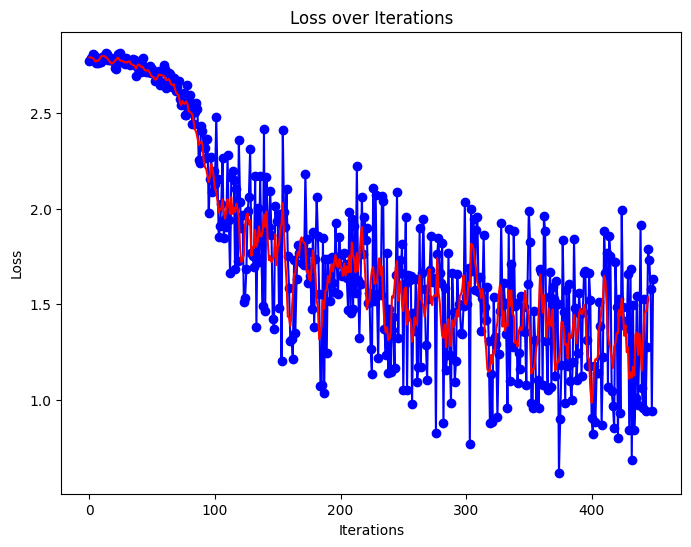

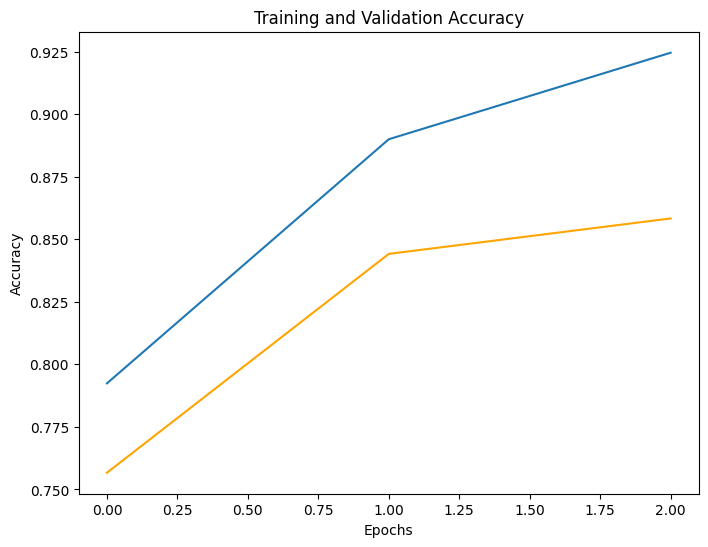

5033 1258


Epoch 1/3:   0%|          | 0/150 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 30.00 MiB. GPU 0 has a total capacity of 22.17 GiB of which 20.88 MiB is free. Process 5974 has 22.14 GiB memory in use. Of the allocated memory 21.61 GiB is allocated by PyTorch, and 294.15 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [19]:
k_fold = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
models = ['convnext' ]

# N=100
# perm_indices = np.random.permutation(N)
# X = X[perm_indices]
# y = y[perm_indices]

for model_name in models:
    current_model_accuracies = []
    for k_id, (train_i, val_i) in enumerate(k_fold.split(X,y)):
        if k_id in [0]:
            continue
        print(len(train_i), len(val_i))
        train_set = X[train_i]
        train_label_set = y[train_i]

        val_set = X[val_i]
        val_label_set = y[val_i]

        model_config = config_manager.config[model_name]
        lr = config_manager.config.lr
        num_epochs = config_manager.config.num_epochs
        num_classes = config_manager.config.num_classes

        device = 'cuda' if torch.cuda.is_available() else 'cpu'

        train_transform = create_train_transforms()
        test_transform = create_test_transforms()

        train_data = PastaData(train_set, train_label_set, transform_list=train_transform)
        train_data_accuracy = PastaData(train_set, train_label_set, transform_list=test_transform)
        val_data = PastaData(val_set, val_label_set, transform_list=test_transform)

        train_loader = DataLoader(train_data, batch_size=model_config.batch_size, shuffle=False, drop_last=True)
        train_loader_accuracy = DataLoader(train_data_accuracy, batch_size=model_config.batch_size, shuffle=False, drop_last=True)
        val_loader = DataLoader(val_data, batch_size=model_config.batch_size, shuffle=False, drop_last=True)

        model = create_model(model_name, num_classes)
        model.to(device)

        result_dir = os.path.join(GOOGLE_DRIVE_PATH, model_config.output_dir)
        os.makedirs(result_dir, exist_ok=True)

        out_file = os.path.join(result_dir, f"{model_name}_k_fold_{k_id}.pt")

        resume = False
        if os.path.exists(out_file):
            print(f"=== {out_file} exist! ===")
            resume = True

        #  need to make dataframe from images
        loss_history, train_accuracy_history, \
        val_accuracy_history, best_accuracy, model, optimizer, scaler, end_epoch = trainer(
            model,
            train_loader,
            train_loader_accuracy,
            val_loader,
            num_epochs=num_epochs,
            lr=lr,
            model_config=model_config,
            device=device,
            resume=resume,
            out_file=out_file,
            num_classes=num_classes
        )


        current_model_accuracies.append(best_accuracy)
        print(f"End of Training for {model_name} Model {k_id}-fold")
        print(f"best accuracy: {best_accuracy}")

        save_model(model, optimizer, scaler, end_epoch, out_file, best_accuracy)
        # torch.save(best_params, os.path.join(result_dir, f"{model_name}_k_fold_{k_id}.pt"))
        draw_loss(loss_history)
        draw_train_val_accuracy(train_accuracy_history, val_accuracy_history)


    print("current_model_accuracies", current_model_accuracies)


        # avg_accuracy = torch.mean(fold_accuracies)
        # std_accuracy = torch.std(fold_accuracies)

        # general plan
        # 1. save best accuracies
        # 2. compare with different models
        # 3. train on full dataset with best performing model
        # 4. make inference


In [ ]:
# Inference

In [20]:
!git pull
!git config --global user.email "tomhyhan@gmail.com"
!git config --global user.name username
!git add .
!git status
!git commit -m "updated trainer"
!git push https://{token}@github.com/{username}/{repo_name}.git

From https://github.com/tomhyhan/noodles
   800a32f..13f83c4  main       -> origin/main
Already up to date.
On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   config/config.yml

[main eccaaf2] updated trainer
 1 file changed, 1 insertion(+), 1 deletion(-)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 12 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 415 bytes | 415.00 KiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/tomhyhan/noodles.git
   13f83c4..eccaaf2  main -> main
